In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import datetime as dt

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables

In [7]:
# We can view all of the classes that automap found
inspector=inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

#get last date in table
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#parse out date from result
last_date1=last_date[0]
#convert string to datetime
last_date_conv = datetime.strptime(last_date1, '%Y-%m-%d')

#subtract 1 year from last date  
query_date = (last_date_conv) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
result=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= query_date).\
    order_by(Measurement.date).all()


Query Date:  2016-08-23 00:00:00


In [29]:
# Load the results into a pandas dataframe. Set the index to the `date`
df = pd.DataFrame(result, columns=['date', 'precip'])
df.set_index('date', inplace=True, )
df.head(10)

,precip
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


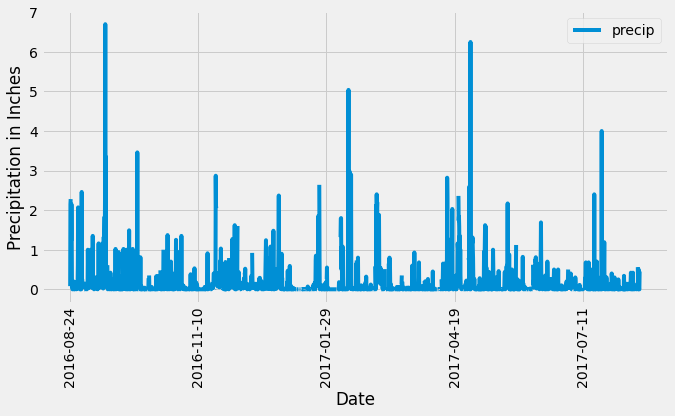

<Figure size 432x288 with 0 Axes>

In [30]:
# Sort the dataframe by date

sorted_df=df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
chart=sorted_df.plot(figsize=(10,5))
chart.set_xlabel('Date')
chart.set_ylabel('Precipitation in Inches')
plt.xticks(rotation='vertical')
plt.show()
plt.tight_layout()


In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()

,precip
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [58]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Station.station).count()
station_count
print(f"The Data Set contains {station_count} stations")

The Data Set contains 9 stations


In [84]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#query measurements
#group by station
sel=[Measurement.station,
    func.count(Measurement.station),
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)]

station_data=session.query(*sel).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

most_active=session.query(Measurement.station).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
most_active=most_active[0]
print(f"The Most active station is {most_active}.")

#create DF for viewing
station_df = pd.DataFrame(station_data, columns=['Station', 'Count','Min','Max','Average'])
station_df.set_index('Station', inplace=True, )
station_df.head(10)


The Most active station is USC00519281.


,Count,Min,Max,Average
Station,,,,
USC00519281,2772,54.0,85.0,71.663781
USC00519397,2724,56.0,87.0,74.553231
USC00513117,2709,59.0,85.0,72.689184
USC00519523,2669,56.0,85.0,74.543649
USC00516128,2612,58.0,84.0,70.915008
USC00514830,2202,58.0,85.0,74.873297
USC00511918,1979,53.0,87.0,71.615968
USC00517948,1372,58.0,87.0,74.684402
USC00518838,511,58.0,83.0,72.724070


In [79]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest=session.query(func.min(Measurement.tobs)).filter(Measurement.station==most_active).all()
lowest=lowest[0]

highest=session.query(func.max(Measurement.tobs)).filter(Measurement.station==most_active).all()
highest=highest[0]

average=session.query(func.avg(Measurement.tobs)).filter(Measurement.station==most_active).all()
average=average[0]

print(f"The Minimum Temperature was: {lowest[0]}")
print(f"The Maximum Temperature was: {highest[0]}")
print(f"The Average Temperature was: {round(average[0],2)}")

The Minimum Temperature was: 54.0
The Maximum Temperature was: 85.0
The Average Temperature was: 71.66


In [95]:
# Choose the station with the highest number of temperature observations.
most_active_temp=session.query(Measurement.station).filter(Measurement.tobs!="NaN").group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()
most_active_temp=most_active_temp[0]
print(f"{most_active_temp} has the most temperature readings.")

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs=session.query(Measurement.tobs).filter(Measurement.date >= query_date).filter(Measurement.station==most_active_temp).\
    all()

# create dataframe
tobs_df = pd.DataFrame(tobs, columns=['Temp'])
#tobs_df.set_index('Station', inplace=True, )
tobs_df.head(10)



USC00519281 has the most temperature readings.


,Temp
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
5,78.0
6,77.0
7,78.0
8,80.0
9,80.0


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
